In [18]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200
from data_helper import UnlabeledDataset, LabeledDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF

from data_helper import *
from helper import collate_fn, draw_box
import model
import model_loader
import torch.optim as optim

In [19]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

class MaskDataset(LabeledDataset):
    def __getitem__(self, index):
        sample, target, road_image = LabeledDataset.__getitem__(self, index)
        road_image = road_image.int()
        
        for i, bb in enumerate(target['bounding_box']):
            point_squence = torch.stack([bb[:, 0], bb[:, 1], bb[:, 3], bb[:, 2], bb[:, 0]])
            x = (point_squence.T[0] * 10 + 400).int()
            y = (-point_squence.T[1] * 10 + 400).int()

            bottom = y.min()
            top = y.max()
            left = x.min()
            right = x.max()

            road_image[bottom:top,left:right] = target['category'][i]

        return sample, road_image.long()
    
# transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
transform = torchvision.transforms.ToTensor()

dataset = MaskDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=False
                                 )
trainloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# net.to(device)
running_loss = 0.0
for i, data in enumerate(trainloader, 0):
    print(i)
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    break

0


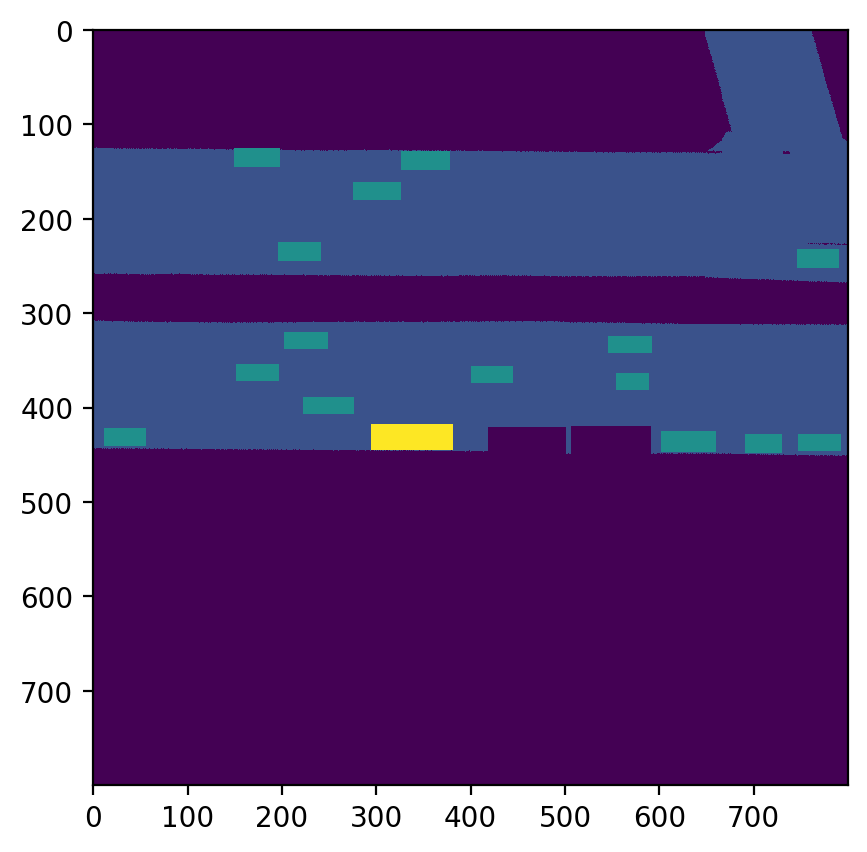

In [20]:
plt.imshow(labels[0])

In [4]:
loader = model_loader.ModelLoader()

In [21]:
bmap = loader.get_binary_road_map(inputs)

In [22]:
outputs = loader.model(inputs)

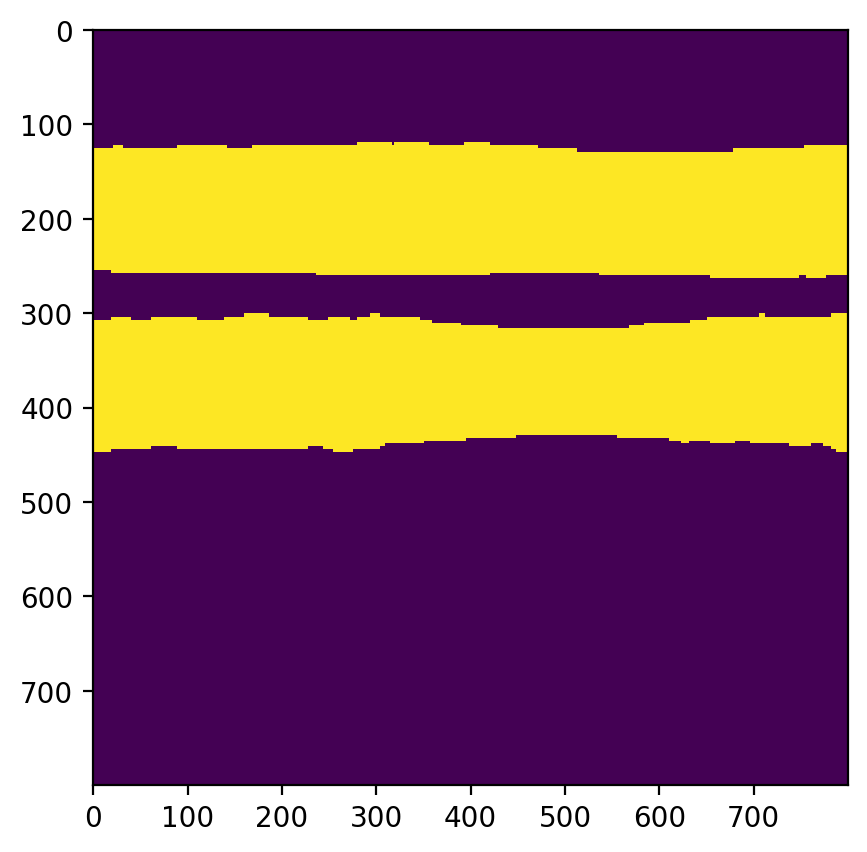

In [23]:
plt.imshow(bmap[0])

In [24]:
bbs = loader.get_bounding_boxes(inputs)

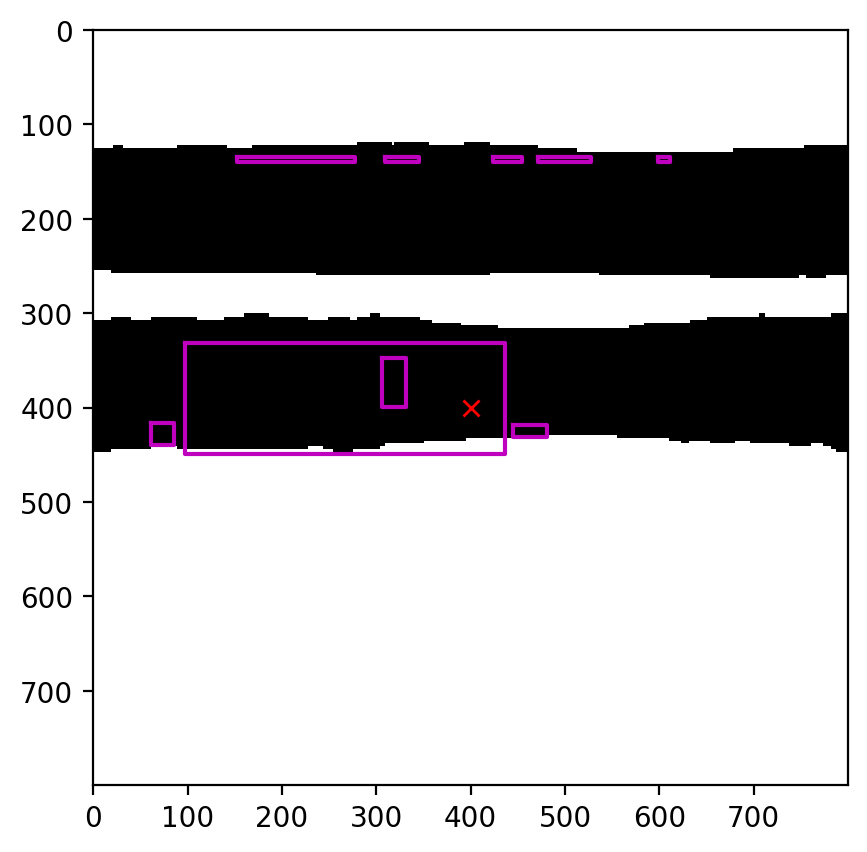

In [25]:
# The center of image is 400 * 400
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(bmap[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for bb in bbs[0]:
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color='m')

In [9]:
outputs = loader.model(inputs)

In [ ]:
d = outputs.detach().numpy()
dc = d.copy()
dc[:,2:,:, :] *= 1.4
plt.imshow(np.argmax(dc[0], axis=0))

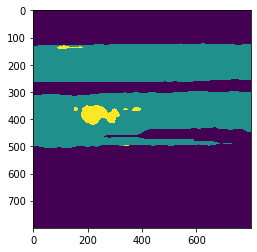

In [11]:
plt.imshow(np.argmax(dc[0], axis=0))

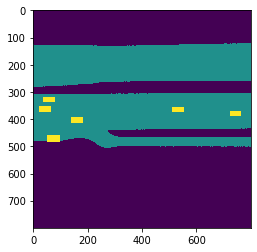

In [12]:
plt.imshow(labels[0])

In [13]:
net = model.Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
net.to(device)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        print(i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print(outputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

0
1
2


KeyboardInterrupt: 

In [ ]:
net.load_state_dict(torch.load('model_sd'))

In [ ]:
net.eval()

In [ ]:
# net.to(device)
running_loss = 0.0
for i, data in enumerate(trainloader, 0):
    print(i)
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward + backward + optimize
    outputs = net(inputs)
    break
    #print(outputs, labels)
    loss = criterion(outputs, labels)

    # print statistics
    running_loss += loss.item()
    if i % 100 == 0:    # print every 2000 mini-batches
        print('[%5d] loss: %.3f' %
              (i + 1, running_loss / (i+1)))

In [ ]:
def get_bounding_boxes(self, samples):
    # samples is a cuda tensor with size [batch_size, 6, 3, 256, 306]
    # You need to return a tuple with size 'batch_size' and each element is a cuda tensor [N, 2, 4]
    # where N is the number of object
    masks = self.model(samples)
    bboxes = torch.tensor([self.model.bounding_boxes(mask) for mask in masks])
    return bboxes

In [ ]:
rmask = roadmask.cpu().numpy()
rmask[2:, :, :] *= 1.4
rmask = np.argmax(rmask, axis=0)
return torch.tensor(rmask > 0)

In [ ]:
roadmaps = torch.stack([net.binary_roadmap(mask) for mask in outputs])

In [ ]:
loader = model_loader.ModelLoader()

In [ ]:
roadmap = loader.get_binary_road_map(inputs)

In [ ]:
plt.imshow(labels[0])

In [ ]:
d = outputs[0].detach().numpy()
dc = d.copy()
# dc[2:, :, :] *= 1.2
plt.imshow(np.argmax(dc, axis=0))

In [ ]:
bboxes[0][0].shape

In [ ]:
# The center of image is 400 * 400
bmap = bmap > 0

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(bmap[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for bb in bboxes[0][:]:
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color='m')

In [ ]:
bboxes[0][1:2]

In [ ]:
bboxes.shape